# 0.0 Business Problem

## Estágio do projeto:
Ciclo 2: Entender os dados e limpa-los (buscar inconsistências) Análises de estatística
    descritiva de primeira ordem

## 0.1 Contexto:
A Insurance All é uma empresa que fornece seguro de saúde para seus clientes e o time de produtos está analisando a possibilidade de oferecer aos assegurados, um novo produto: Um seguro de automóveis.

Assim como o seguro de saúde, os clientes desse novo plano de seguro de automóveis precisam pagar um valor anualmente à Insurance All para obter um valor assegurado pela empresa, destinado aos custos de um eventual acidente ou dano ao veículo.

A Insurance All fez uma pesquisa com cerca de 380 mil clientes sobre o interesse em aderir a um novo produto de seguro de automóveis, no ano passado. Todos os clientes demonstraram interesse ou não em adquirir o seguro de automóvel e essas respostas ficaram salvas em um banco de dados junto com outros atributos dos clientes.

O time de produtos selecionou 127 mil novos clientes que não responderam a pesquisa para participar de uma campanha, no qual receberão a oferta do novo produto de seguro de automóveis. A oferta será feita pelo time de vendas através de ligações telefônicas.

Projeto retirado do Blog Seja Um Data Scientist
https://sejaumdatascientist.com/como-usar-data-science-para-fazer-a-empresa-vender-mais/

Projeto original disponível na plataforma Kaggle
https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction


## 0.2 Estratégia da Solução:

###### 0.2.1 Objetivos:
1. Principais Insights sobre os atributos mais relevantes de clientes interessados em adquirir um seguro de automóvel.
2. Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel, o time de vendas conseguirá contatar fazendo 20.000 ligações?
3. E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?
4. Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

###### 0.2.2 Proposta de Solução:
1. Gráficos e estudos de como as features se relacionam com a variávei alvo, individualmente ou combinadas através de Exploratory Data Analysis e Descriptive Statistics.
2. Treinar um modelo de Machine Learning, scorar os clientes, priorizar os clientes segundo suas probabilidades de sucesso, utilizar das métricas para criar cenários com os 20.000 melhores.
3. Utilizar do modelo anterior e criar cenários com os 40.000 melhores.
4. Utilizar do modelo anterior, definir curva de probabilidades para todos os clientes e identificar ponto crítico.
5. Fazer deploy e disponibilizar online através do Heroku

###### 0.2.3 Inputs:
1. Problema de negócio
2. Conjunto de dados com características de 380.000 clientes e as suas respostas sobre interesse em adquirir um seguro de automóveis.

###### 0.2.4 Outputs:
1. Gráficos e parâmetros em uma tabela no notebook (Gráfico / Parâmetros)
2. Resposta objetiva em um notebook (Uma porcentagem)
3. Resposta objetiva em um notebook (Uma porcentagem)
4. Resposta objetiva em um notebook (Um número absoluto)
5. Tabela de banco de dados SQL com todas as classificações
6. API com request/predict do tipo: | v1 | v2 | v3 | - 1/0

###### 0.2.5 Ciclos:
1. Pipeline de dados, funcional, de ponta a ponta (desde a coleta de dados até o 
    treinamento do modelo)
2. Entender os dados e limpa-los (buscar inconsistências) Análises de estatística
    descritiva de primeira ordem
3. Feature Engineering (criar variáveis que modelam o fenômeno)
4. Criar as hipóteses de negócio
5. Análise exploratória de dados para validar ou refutar hióteses
6. Definir métricas e treinar o modelo
7. Analisar métricas
8. Criar arquivo handle para todas as transformações necessárias
9. Criar API
10. Resultados e Conclusão

## 0.3 Sumário:

## 0.4 Resultados e Conclusão:

# 1.0 Imports

###### 1.1 Libraries

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import shapiro, kstest

from xgboost import XGBClassifier

from boruta import BorutaPy

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from scipy.stats import ttest_ind

import pickle

import time
import warnings

# Tempo de processamento
time_agora = time.time()

###### 1.2 Helper Functions

In [2]:
# Função inferência
def comparar_features(series1, series2, confiança, qtd_amostras):
    print('Series 1')
    print(f'Média = {round(series1.mean(), 2)}')
    print(f'Desvio padrão = {round(series1.std(), 2)}')
    print()
    print('Series 2')
    print(f'Média = {round(series2.mean(), 2)}')
    print(f'Desvio padrão = {round(series2.std(), 2)}')
    aleatório1 = np.random.choice(series1.dropna(), qtd_amostras)
    aleatório2 = np.random.choice(series2.dropna(), qtd_amostras)
    stat, p = ttest_ind(aleatório1, aleatório2)
    print(f'statistic = {round(stat, 2)}, p = {round(p, 2)}')
  
    if p < confiança:
        print(f'\nCom um p-valor igual à {round(p, 2)}, as series são estatísticamente DIFERENTES com um grau de confiança de {round(100-confiança*100)}%')
    if p > confiança:
        print(f'\nCom um p-valor igual à {round(p, 2)}, as series são estatísticamente IGUAIS com um grau de confiança de {round(100-confiança*100)}%')


# Função buscar outlier pelo método do 6 Sigma
def buscar_outlier(df, series):
    média = df[series].mean()
    desvio_padrão = df[series].std()
    lis = média - (desvio_padrão * 3)
    lss = média + (desvio_padrão * 3)
    lista_outliers = df[(df[series] < lis) | (df[series] > lss)].index
    return lista_outliers, lis, lss

# Análise descritiva de primeira ordem
def analise_descritiva(x):
    print(f'A média da Series é: {round(np.mean(x), 2)}')
    print(f'O valor máximo da Series é: {np.max(x)}')
    print(f'O valor mínimo da Series é: {np.min(x)}')
    print(f'O range é de: {np.max(x)-np.min(x)}')
    print(f'O desvio padrão da Series é: {round(np.std(x), 2)}')
    print(f'A curtose da Series é: {round(x.kurtosis(), 2)}')
    print(f'A skew da Series é: {round(x.skew(), 2)}')
    
# Teste de Shapiro
def teste_shapiro(df, series):
    random_index = np.random.choice(df.index, 500)
    temp = df.loc[random_index]
    shapiro_test = shapiro(temp[series].dropna())
    if shapiro_test.pvalue > 0.05:
        print(f'Com um p-valor = {round(shapiro_test.pvalue, 3)}, e alpha de 5%, falha em rejeitar a hipótese nula.')
    else:
        print(f'Com um p-valor = {round(shapiro_test.pvalue, 3)}, e alpha de 5%, rejeita a hipótese nula.')

###### 1.3 Loading Dataset

In [3]:
train = pd.read_csv(r'C:\\Users\Notebook\\Google Drive\\Pessoal\\Projetos\\insurance_sales_predict\\train.csv')
test = pd.read_csv(r'C:\\Users\Notebook\\Google Drive\\Pessoal\\Projetos\\insurance_sales_predict\\test.csv')

###### 1.4 Concating Train and Test into a Matrix Dataset

In [4]:
df = pd.concat([train, test])

###### 1.5 Creating Submission Table

In [5]:
submission = pd.DataFrame()
submission['id'] = test['id']

# 2.0 General Analysis and Data Cleaning

## 2.1 Main insights:

###### Response:
1. Desbalanceada com 12% de eventos positivos
2. Correlação fraca com Vehicle_Damage e correlação fraca negativa com Previously_Insured

###### Gender:
1. Balanceada
2. Correlações muito fracas
3. Homens se interessam 30% mais no produto em relação às mulheres

###### Vehicle_Age:
1. Mais da metade dos clientes possuem carros com menos de 1 ano
2. Correlação moderada negativa com Age, fraca positiva com Policy_Sales_Channel
3. Médias de response bastante distintas

###### Vehicle_Damage:
1. Balanceada
2. Correlação muito forte negativa com Previously_Insured, fraca negativa com Policy_Sales_Channel, fraca positiva com Response e Age
3. Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

###### Driving_License:
1. Correlações muito fracas
2. 99% dos clientes são habilitados
3. Habilitados apresentam 5% de interesse no produto, não habilitados apresentam 12% de interesse no produto.

###### Previously_Insured:
1. 45% dos clientes já possuem seguro veicular
2. Clientes que já possuem seguro têm interesse quase zero pelo produto
3. Correlação muito forte negativa com Vehicle_Damage, fraca negativa com Response e Age, e fraca positiva com Policy_Sales_Channel

###### Region_Code:
1. 53 regiões
2. 28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais numerosas
3. A região 28 (mais importante) tem por volta de 18% de probabilidade de response, segunda melhor região, atrás apenas da região 38.
4. As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%
5. Médias de response bastante distintas, com desvios padrões baixos

###### Policy_Sales_Channel:
1. Há 157 Policy_Sales_Channel e aproximadamente um terço das amostras está contido no canal 152
2. 5 categorias contém 84.19% do total de clientes
3. Correlação moderada negativa com Age, correlação fraca negativa com Vehicle_Damage, correlação fraca positiva com Vehicle_Age e Previously_Insured
4. Médias de response por canais de Policy_Sales_Channel bastante distintas
5. Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

###### Vintage:
1. Feature categórica, há 290 categorias em Vintage

###### Age:
1. Range de idade de 25 até 85 anos, aparentemente sem erros de input
2. Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.
3. Sem outliers
4. A média de idade entre os que não se interessam pelo produto é de 38 anos, e dos que se interessam é de 43 anos.
5. Pessoas com mais de 30 anos apresentam um interesse relativamente maior pelo produto.
6. Correlações moderadas negativas com Policy_Sales_Channel e Vehicle_Age, fraca negativa com Previously_Insured e fraca positiva com Vehicle_Damage

###### Annual_Premium
1. 2799 em Annual_Premmium, não aparentam ser por conta de erros de input
2. Há dois grupos de clientes, um com valores fixos em 2630 dollares, e outro com valores contínuos e superiores, não há diferença significativa de média de interesse no produto entre os grupos
3. Aparentemente acima do terceiro quartil da distribuição há um interesse maior no produto

## 2.2 Data Descriptions

###### 2.1.1 Data dimensions

In [6]:
print(f'Number of rows: {train.shape[0]}')
print(f'Number of columns: {train.shape[1]}')

Number of rows: 381109
Number of columns: 12


###### 2.1.2 Data types

In [7]:
train.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

###### 2.1.3 Look table

In [8]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Gender, Vehicle_Age, Vehicle_Damage precisam ser transformados para que possam haver estudos de correlação

###### 2.1.4 Changing Interesting datatypes

In [9]:
Gender_le = LabelEncoder()
Gender_le.fit(df['Gender'])
df['Gender_'] = Gender_le.transform(df['Gender'])

Vehicle_Damage_le = LabelEncoder()
Vehicle_Damage_le.fit(df['Vehicle_Damage'])
df['Vehicle_Damage_'] = Vehicle_Damage_le.transform(df['Vehicle_Damage'])

Vehicle_Age_le = LabelEncoder()
Vehicle_Age_le.fit(df['Vehicle_Age'])
df['Vehicle_Age_'] = Vehicle_Age_le.transform(df['Vehicle_Age'])

###### 2.1.5 Segregating feature types

In [10]:
features_id = ['id']
features_string = ['Gender', 'Vehicle_Damage', 'Vehicle_Age']
features_categóricas = ['Gender_', 'Vehicle_Damage_', 'Vehicle_Age_', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Policy_Sales_Channel', 'Vintage']
features_numéricas = ['Age', 'Annual_Premium']
target = ['Response']

###### 2.1.6 Check NaN values

In [11]:
df.isna().sum()

id                           0
Gender                       0
Age                          0
Driving_License              0
Region_Code                  0
Previously_Insured           0
Vehicle_Age                  0
Vehicle_Damage               0
Annual_Premium               0
Policy_Sales_Channel         0
Vintage                      0
Response                127037
Gender_                      0
Vehicle_Damage_              0
Vehicle_Age_                 0
dtype: int64

Sem valores nulos

## 2.3 Descriptive Statistics

### 2.2.1 Target

In [12]:
print(f'A porcentagem de interessados no produto é: {round(df["Response"].mean(), 2) * 100} %')

A porcentagem de interessados no produto é: 12.0 %


Desbalanceada

### 2.2.2 Numerical Features

In [13]:
df[features_numéricas].describe()

,Age,Annual_Premium
count,508146.000000,508146.000000
mean,38.808413,30554.453041
std,15.500179,17146.574625
min,20.000000,2630.000000
25%,25.000000,24381.000000
50%,36.000000,31661.000000
75%,49.000000,39403.750000
max,85.000000,540165.000000


Range de idade entre 20 e 85 anos, sem indícios de erros de inputs, Annual_Premium com possíveis outliers

###### Age

In [14]:
analise_descritiva(df['Age'])

A média da Series é: 38.81
O valor máximo da Series é: 85
O valor mínimo da Series é: 20
O range é de: 65
O desvio padrão da Series é: 15.5
A curtose da Series é: -0.56
A skew da Series é: 0.67


###### Annual_Premium

In [15]:
analise_descritiva(df['Annual_Premium'])

A média da Series é: 30554.45
O valor máximo da Series é: 540165.0
O valor mínimo da Series é: 2630.0
O range é de: 537535.0
O desvio padrão da Series é: 17146.56
A curtose da Series é: 30.05
A skew da Series é: 1.6


### 2.2.3 Categorical Features

In [16]:
df[features_categóricas].astype('category').describe()

,Gender_,Vehicle_Damage_,Vehicle_Age_,Driving_License,Region_Code,Previously_Insured,Policy_Sales_Channel,Vintage
count,508146,508146,508146,508146,508146.0,508146,508146.0,508146
unique,2,2,3,2,53.0,2,157.0,290
top,1,1,0,1,28.0,0,152.0,256
freq,274325,256248,267015,507097,141937.0,275076,179523.0,1877


In [17]:
Gender_le.inverse_transform([0])

array(['Female'], dtype=object)

In [18]:
Vehicle_Damage_le.inverse_transform([1])

array(['Yes'], dtype=object)

In [19]:
Vehicle_Age_le.inverse_transform([1])

array(['< 1 Year'], dtype=object)

Sexo relativamente balanceado com a maioria de mulheres, maior parte dos clientes possuem veículos com menos de 1 ano, maior parte dos clientes já teve danos em seu veículo, habilitação para dirigir balanceado, há 53 regiões diferentes e por volta de 30% dos clientes estão contidos na região 28, um pouco mais que 50% dos clientes não possuem seguro veicular, há 157 canais de vendas, e por volta de 35% dos clientes estão contidos no canal 152.

### 2.2.4 Features Individual Analysis

#### Response

###### Principais Insights:
1. Desbalanceada com 12% de eventos positivos
2. Correlação fraca com Vehicle_Damage e correlação fraca negativa com Previously_Insured

###### General Analysis

In [20]:
df['Response'].mean()

0.12256336113815208

In [21]:
df.corr()['Response'].sort_values(ascending=False)[1:]

Vehicle_Damage_         0.354400
Age                     0.111147
Gender_                 0.052440
Annual_Premium          0.022575
Region_Code             0.010570
Driving_License         0.010155
Vintage                -0.001050
id                     -0.001368
Vehicle_Age_           -0.104078
Policy_Sales_Channel   -0.139042
Previously_Insured     -0.341170
Name: Response, dtype: float64

Correlação fraca com Vehicle_Damage e correlação fraca negativa com Previously_Insured

#### Gender

###### Principais Insights:
1. Balanceada
2. Correlações muito fracas
3. Homens se interessam 30% mais no produto em relação às mulheres

###### General Analysis

In [22]:
df.corr()['Gender_'].sort_values(ascending=False)[1:]

Age                     0.146573
Vehicle_Damage_         0.092273
Response                0.052440
Annual_Premium          0.003502
Region_Code             0.000684
id                     -0.001765
Vintage                -0.002098
Driving_License        -0.017720
Previously_Insured     -0.082726
Policy_Sales_Channel   -0.111565
Vehicle_Age_           -0.113453
Name: Gender_, dtype: float64

Correlações muito fracas

In [23]:
Gender_le.inverse_transform([0])

array(['Female'], dtype=object)

In [24]:
print(f'{round(df.loc[df["Gender_"]==0, "Response"].mean() *100, 2)}% das mulheres se interessam pelo produto.')
print(f'{round(df.loc[df["Gender_"]==1, "Response"].mean() *100, 2)}% dos homens se interessam pelo produto.')

10.39% das mulheres se interessam pelo produto.
13.84% dos homens se interessam pelo produto.


#### Age

###### Principais Insights:
1. Range de idade de 25 até 85 anos, aparentemente sem erros de input
2. Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.
3. Sem outliers
4. A média de idade entre os que não se interessam pelo produto é de 38 anos, e dos que se interessam é de 43 anos.
5. Pessoas com mais de 30 anos apresentam um interesse relativamente maior pelo produto.
6. Correlações moderadas negativas com Policy_Sales_Channel e Vehicle_Age, fraca negativa com Previously_Insured e fraca positiva com Vehicle_Damage

###### General Analysis

In [25]:
df.corr()['Age'].sort_values(ascending=False)[1:]

Vehicle_Damage_         0.268328
Gender_                 0.146573
Response                0.111147
Annual_Premium          0.067392
Region_Code             0.041649
Vintage                -0.000010
id                     -0.000643
Driving_License        -0.079660
Previously_Insured     -0.255582
Vehicle_Age_           -0.522770
Policy_Sales_Channel   -0.577043
Name: Age, dtype: float64

Correlações moderadas negativas com Policy_Sales_Channel e Vehicle_Age, fraca negativa com Previously_Insured e fraca positiva com Vehicle_Damage

<AxesSubplot:xlabel='Age', ylabel='Count'>

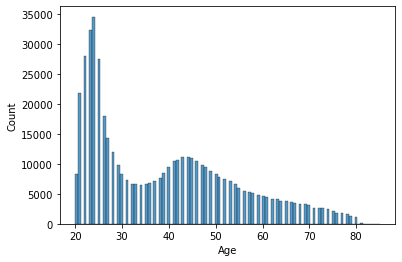

In [26]:
sns.histplot(df['Age'])

Apresenta uma distribuição com uma certa semelhança com uma Poison, mas com uma segunda moda em um ponto próximo aos 45 anos.

In [27]:
analise_descritiva(df['Age'])

A média da Series é: 38.81
O valor máximo da Series é: 85
O valor mínimo da Series é: 20
O range é de: 65
O desvio padrão da Series é: 15.5
A curtose da Series é: -0.56
A skew da Series é: 0.67


In [28]:
índices, li, ls = buscar_outlier(df, 'Age')

In [29]:
df.loc[índices]

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Gender_,Vehicle_Damage_,Vehicle_Age_


C:\Users\Notebook\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age'>

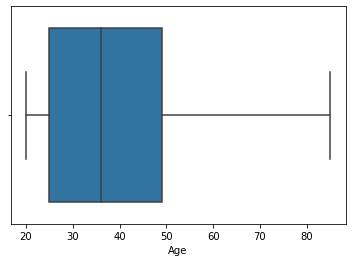

In [30]:
sns.boxplot(df['Age'])

sem outliers

In [31]:
print(f'A média de idade entre os que NÃO se interessam pelo produto: {round(df.loc[df["Response"]==0, "Age"].mean(), 2)}%')
print(f'A média de idade entre os que se interessam pelo produto: {round(df.loc[df["Response"]==1, "Age"].mean(), 2)}%')

A média de idade entre os que NÃO se interessam pelo produto: 38.18%
A média de idade entre os que se interessam pelo produto: 43.44%


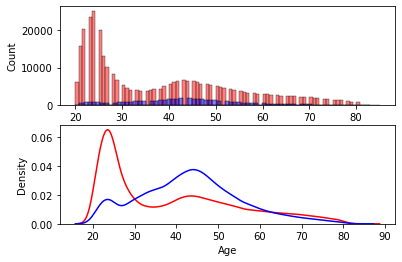

In [32]:
plt.subplot(2, 1, 1)
g = sns.histplot(df.loc[df['Response']==0, 'Age'], color='r', alpha=0.5)
g = sns.histplot(df.loc[df['Response']==1, 'Age'], color='b', alpha=0.5)
plt.subplot(2, 1, 2)
g = sns.kdeplot(df.loc[df['Response']==0, 'Age'], color='r', alpha=0.5)
g = sns.kdeplot(df.loc[df['Response']==1, 'Age'], color='b', alpha=0.5)

Pessoas mais velhas apresentam maior interesse no produto

#### Driving_License

###### Principais Insights:
1. Correlações muito fracas
2. 99% dos clientes são habilitados
3. Habilitados apresentam 5% de interesse no produto, não habilitados apresentam 12% de interesse no produto.

###### General Analysis

In [33]:
df.corr()['Driving_License'].sort_values(ascending=False)[1:]

Policy_Sales_Channel    0.042862
Vehicle_Age_            0.030010
Previously_Insured      0.014370
Response                0.010155
id                      0.001362
Region_Code            -0.000202
Vintage                -0.000850
Annual_Premium         -0.012084
Vehicle_Damage_        -0.015784
Gender_                -0.017720
Age                    -0.079660
Name: Driving_License, dtype: float64

Correlações muito fracas

In [34]:
print(f'{round(df["Driving_License"].mean(), 3)}% dos clientes são habilitados')

0.998% dos clientes são habilitados


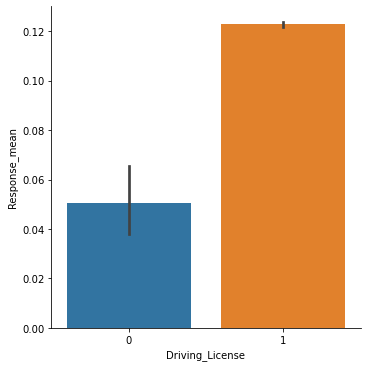

In [35]:
sns.catplot(x='Driving_License', y= 'Response', data=df, kind='bar')
plt.ylabel('Response_mean');

In [36]:
print(f'Habilitados tem: {round(df.loc[df["Driving_License"]==0, "Response"].mean()*100, 2)}% de interesse no produto')
print(f'NÃO habilitados tem: {round(df.loc[df["Driving_License"]==1, "Response"].mean()*100, 2)}% de interesse no produto')

Habilitados tem: 5.05% de interesse no produto
NÃO habilitados tem: 12.27% de interesse no produto


#### Previously_Insured

###### Principais Insights:
1. 45% dos clientes já possuem seguro veicular
2. Clientes que já possuem seguro têm interesse quase zero pelo produto
3. Correlação muito forte negativa com Vehicle_Damage, fraca negativa com Response e Age, e fraca positiva com Policy_Sales_Channel

###### General Analysis

In [37]:
df.corr()['Previously_Insured'].sort_values(ascending=False)[1:]

Policy_Sales_Channel    0.221334
Vehicle_Age_            0.175548
Driving_License         0.014370
Annual_Premium          0.004776
id                      0.002557
Vintage                 0.001664
Region_Code            -0.023991
Gender_                -0.082726
Age                    -0.255582
Response               -0.341170
Vehicle_Damage_        -0.823973
Name: Previously_Insured, dtype: float64

Correlação muito forte negativa com Vehicle_Damage, fraca negativa com Response e Age, e fraca positiva com Policy_Sales_Channel

In [38]:
df['Previously_Insured'].mean()

0.45866739086797886

45% dos clientes já sofreram danos veiculares

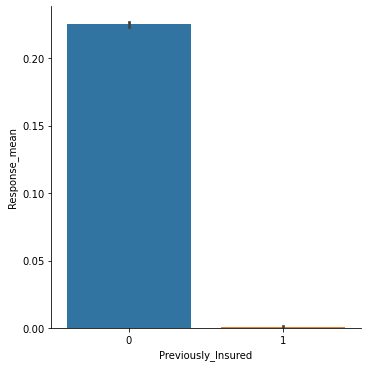

In [39]:
sns.catplot(x='Previously_Insured', y='Response', data=df, kind='bar')
plt.ylabel('Response_mean');

In [40]:
df.loc[df['Previously_Insured']==1, 'Response'].mean()*100

0.09047804475799986

Clientes que possuem seguro veicular tem interesse quase zero no produto

#### Region_Code

###### Principais Insights:
1. 53 regiões
2. 28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais numerosas
3. A região 28 (mais importante) tem por volta de 18% de probabilidade de response, segunda melhor região, atrás apenas da região 38.
4. As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%
5. Médias de response bastante distintas, com desvios padrões baixos

###### General Analysis:

In [41]:
df.corr()['Region_Code'].sort_values(ascending=False)[1:]

Age                     0.041649
Vehicle_Damage_         0.027210
Response                0.010570
id                      0.001325
Gender_                 0.000684
Driving_License        -0.000202
Vintage                -0.001568
Annual_Premium         -0.012012
Previously_Insured     -0.023991
Vehicle_Age_           -0.027622
Policy_Sales_Channel   -0.042223
Name: Region_Code, dtype: float64

Correlações muito fracas

In [42]:
df['Region_Code'].nunique()

53

53 categorias

In [43]:
df['Region_Code'].value_counts(normalize=True).head(5)

28.0    0.279323
8.0     0.088360
46.0    0.051869
41.0    0.048018
15.0    0.034931
Name: Region_Code, dtype: float64

In [44]:
df['Region_Code'].value_counts(normalize=True).tail(5)

1.0     0.002682
44.0    0.002094
42.0    0.001549
52.0    0.000703
51.0    0.000533
Name: Region_Code, dtype: float64

In [45]:
df['Region_Code'].value_counts(normalize=True).head(5).sum()

0.5025012496408512

28% dos clientes está contido na região 28. 50% dos dados estão contidos nas 5 regiões mais densas.

In [46]:
df.groupby('Region_Code', as_index=False).agg({'Response':'mean'}).sort_values('Response', ascending=False).head(5)

,Region_Code,Response
38,38.0,0.192004
28,28.0,0.187163
19,19.0,0.162866
4,4.0,0.158245
23,23.0,0.153061


In [47]:
df.groupby('Region_Code', as_index=False).agg({'Response':'mean'}).sort_values('Response', ascending=False).tail(5)

,Region_Code,Response
22,22.0,0.063407
50,50.0,0.062677
10,10.0,0.060128
25,25.0,0.042749
44,44.0,0.040842


As regiões com probabilidade de response mais alto estão com por volta de 19%, as regiões com probabilidades mais baixas estã em por volta de 4%

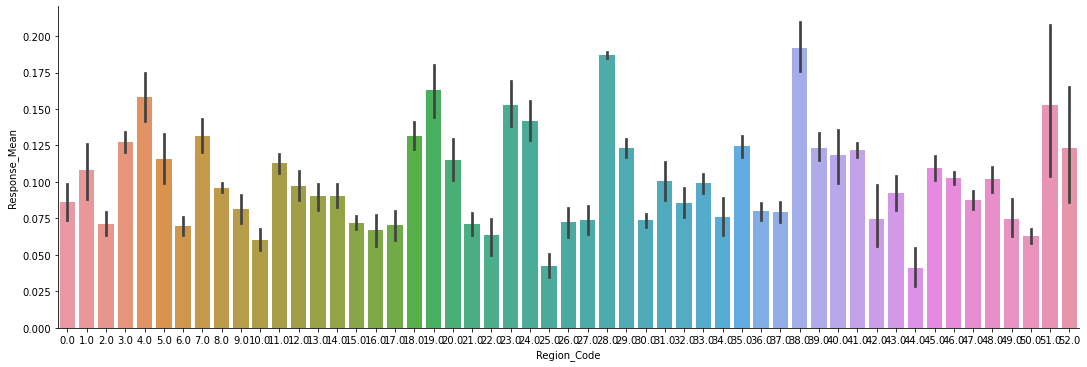

In [48]:
sns.catplot(x='Region_Code', y='Response', data=df, kind='bar', aspect=3)
plt.ylabel('Response_Mean');

Médias de response bastante distintas, com desvios padrões baixos

#### Vehicle_Age

###### Principais insights:
1. Mais da metade dos clientes possuem carros com menos de 1 ano
2. Correlação moderada negativa com Age, fraca positiva com Policy_Sales_Channel
3. Médias de response bastante distintas

###### General Analysis

In [49]:
df.corr()['Vehicle_Age_'].sort_values(ascending=False)[1:]

Policy_Sales_Channel    0.388868
Previously_Insured      0.175548
Driving_License         0.030010
Annual_Premium          0.023545
Vintage                 0.001941
id                     -0.000359
Region_Code            -0.027622
Response               -0.104078
Gender_                -0.113453
Vehicle_Damage_        -0.174990
Age                    -0.522770
Name: Vehicle_Age_, dtype: float64

Correlação moderada negativa com Age, fraca positiva com Policy_Sales_Channel

In [50]:
df['Vehicle_Age'].value_counts(normalize=True)

1-2 Year     0.525469
< 1 Year     0.432563
> 2 Years    0.041968
Name: Vehicle_Age, dtype: float64

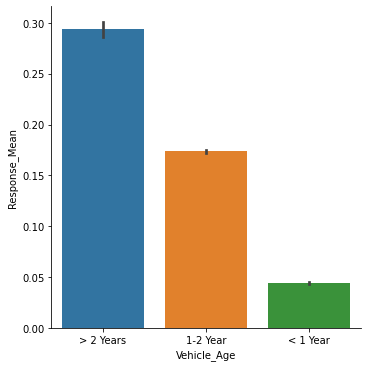

In [51]:
sns.catplot(x='Vehicle_Age', y='Response', data=df, kind='bar')
plt.ylabel('Response_Mean');

Médias de response bastante distintas

#### Vehicle_Damage

###### Principais insights:
1. Balanceada
2. Correlação muito forte negativa com Previously_Insured, fraca negativa com Policy_Sales_Channel, fraca positiva com Response e Age
3. Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

###### General Analysis

In [52]:
df.corr()['Vehicle_Damage_'].sort_values(ascending=False)[1:]

Response                0.354400
Age                     0.268328
Gender_                 0.092273
Region_Code             0.027210
Annual_Premium          0.009504
Vintage                -0.001078
id                     -0.002335
Driving_License        -0.015784
Vehicle_Age_           -0.174990
Policy_Sales_Channel   -0.225856
Previously_Insured     -0.823973
Name: Vehicle_Damage_, dtype: float64

Correlação muito forte negativa com Previously_Insured, fraca negativa com Policy_Sales_Channel, fraca positiva com Response e Age

In [53]:
df['Vehicle_Damage'].value_counts(normalize=True)

Yes    0.50428
No     0.49572
Name: Vehicle_Damage, dtype: float64

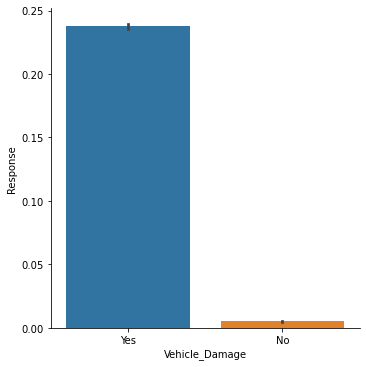

In [54]:
sns.catplot(x='Vehicle_Damage', y='Response', data=df, kind='bar')

In [55]:
print(f'Clientes que já tiveram danos tem: {round(df.loc[df["Vehicle_Damage"]=="Yes", "Response"].mean()*100, 2)}% de response')
print(f'Clientes que NÃO tiveram danos tem: {round(df.loc[df["Vehicle_Damage"]=="No", "Response"].mean()*100, 2)}% de response')

Clientes que já tiveram danos tem: 23.77% de response
Clientes que NÃO tiveram danos tem: 0.52% de response


Clientes que já tiveram danos no seu veículo tem 24% de response, enquanto clientes que não tiveram danos têm por volta de 1%

#### Annual_Premium

###### Principais insights:
1. 2799 em Annual_Premmium, não aparentam ser por conta de erros de input
2. Há dois grupos de clientes, um com valores fixos em 2630 dollares, e outro com valores contínuos e superiores, não há diferença significativa de média de interesse no produto entre os grupos
3. Aparentemente acima do terceiro quartil da distribuição há um interesse maior no produto

###### General Analysis

<AxesSubplot:xlabel='Annual_Premium'>

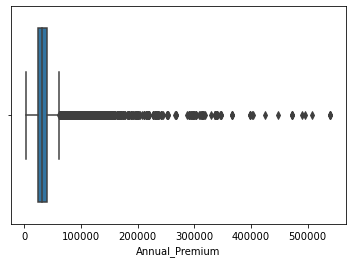

In [56]:
sns.boxplot(x='Annual_Premium', data=df)

Muitos outliers

In [57]:
índices, li, ls = buscar_outlier(df, 'Annual_Premium')

In [58]:
print(f'Há {len(índices)} outliers no total')

Há 2799 outliers no total


In [59]:
df.corr()['Annual_Premium'].sort_values(ascending=False)[1:]

Age                     0.067392
Vehicle_Age_            0.023545
Response                0.022575
Vehicle_Damage_         0.009504
Previously_Insured      0.004776
Gender_                 0.003502
id                      0.001042
Vintage                -0.000855
Region_Code            -0.012012
Driving_License        -0.012084
Policy_Sales_Channel   -0.114035
Name: Annual_Premium, dtype: float64

Correlações muito fracas

<AxesSubplot:xlabel='Annual_Premium', ylabel='Count'>

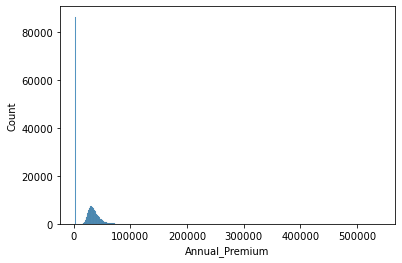

In [60]:
sns.histplot(df['Annual_Premium'])

In [61]:
df['Annual_Premium'].value_counts(normalize=True).head(5)

2630.0     0.170203
69856.0    0.000364
45179.0    0.000112
38452.0    0.000110
39008.0    0.000108
Name: Annual_Premium, dtype: float64

17% dos clientes estão contidos em um valor discreto de 2630 dollares. Um estudo separadamente para este grupo pode ser interessante.

In [62]:
print(f'A média de interesse no produto do grupo de clientes com valor FIXO de seguro: {round(df.loc[df["Annual_Premium"]==2630, "Response"].mean()*100, 2)}%')
print(f'A média de interesse no produto do grupo de clientes com valor VARIÁVEL SUPERIOR de seguro: {round(df.loc[df["Annual_Premium"]!=2630, "Response"].mean()*100, 2)}%')

A média de interesse no produto do grupo de clientes com valor FIXO de seguro: 13.11%
A média de interesse no produto do grupo de clientes com valor VARIÁVEL SUPERIOR de seguro: 12.08%


O interesse no produto não é significativamente diferente entre os dois grupos de clientes

Para uma melhor visualização, os dados serão filtrados provisioriamente até 100000 dollares

In [63]:
temp = df.loc[(df['Annual_Premium']>2630)&(df['Annual_Premium']<100000)]

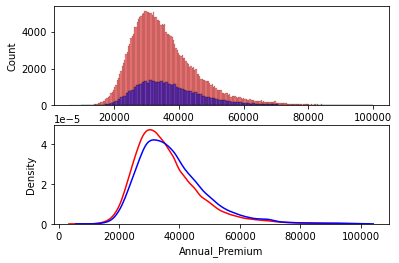

In [64]:
plt.subplot(2, 1, 1)
g = sns.histplot(temp.loc[temp['Response']==0, 'Annual_Premium'], color='r', alpha=0.5)
g = sns.histplot(temp.loc[temp['Response']==1, 'Annual_Premium'], color='b', alpha=0.5)
plt.subplot(2, 1, 2)
g = sns.kdeplot(temp.loc[temp['Response']==0, 'Annual_Premium'], color='r', alpha=0.5)
g = sns.kdeplot(temp.loc[temp['Response']==1, 'Annual_Premium'], color='b', alpha=0.5)

Aparentemente acima do terceiro quartil da distribuição há um interesse maior no produto

#### Policy_Sales_Channel

###### Main insights:
1. Há 157 Policy_Sales_Channel e aproximadamente um terço das amostras está contido no canal 152
2. 5 categorias contém 84.19% do total de clientes
3. Correlação moderada negativa com Age, correlação fraca negativa com Vehicle_Damage, correlação fraca positiva com Vehicle_Age e Previously_Insured
4. Médias de response por canais de Policy_Sales_Channel bastante distintas
5. Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

###### General Analysis

In [65]:
df.corr()['Policy_Sales_Channel'].sort_values(ascending=False)[1:]

Vehicle_Age_          0.388868
Previously_Insured    0.221334
Driving_License       0.042862
Vintage              -0.000814
id                   -0.002812
Region_Code          -0.042223
Gender_              -0.111565
Annual_Premium       -0.114035
Response             -0.139042
Vehicle_Damage_      -0.225856
Age                  -0.577043
Name: Policy_Sales_Channel, dtype: float64

Correlação moderada negativa com Age, correlação fraca negativa com Vehicle_Damage, correlação fraca positiva com Vehicle_Age e Previously_Insured

In [66]:
df['Policy_Sales_Channel'].value_counts(normalize=True).head(5)

152.0    0.353290
26.0     0.209770
124.0    0.193446
160.0    0.057247
156.0    0.028167
Name: Policy_Sales_Channel, dtype: float64

In [67]:
canais_mais_utilizados = df['Policy_Sales_Channel'].value_counts(normalize=True).head(5).index

In [68]:
print(f'5 categorias contém {round(df["Policy_Sales_Channel"].value_counts(normalize=True).head(5).sum()*100, 2)}% do total de clientes')

5 categorias contém 84.19% do total de clientes


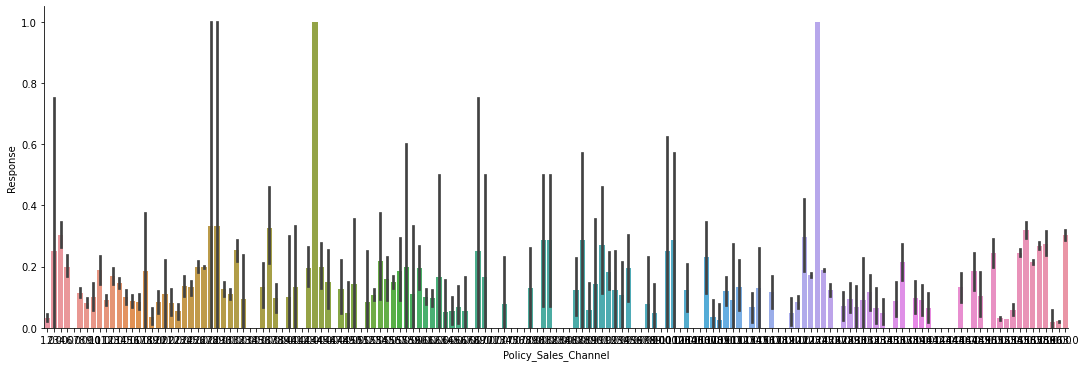

In [69]:
sns.catplot(x='Policy_Sales_Channel', y='Response', data=df, kind='bar', aspect=3)

Médias de response por canais de Policy_Sales_Channel bastante distintas

In [70]:
temp = df.groupby('Policy_Sales_Channel', as_index=False).agg({'Response':'count'})
temp.rename(columns={'Response':'Response_Count'}, inplace=True)

temp2 = df.groupby('Policy_Sales_Channel', as_index=False).agg({'Response':'mean'})
temp2.rename(columns={'Response':'Response_Mean'}, inplace=True)

temp3 = temp.merge(temp2, how='left', on='Policy_Sales_Channel')
temp3.sort_values('Response_Count', ascending=False).head(5)

,Policy_Sales_Channel,Response_Count,Response_Mean
147,152.0,134784,0.028624
24,26.0,79700,0.199385
119,124.0,73995,0.189148
155,160.0,21779,0.021810
151,156.0,10661,0.215458


Os canais mais utilizados apresentam médias de response bastante diferentes da média global, os canal 152 é o mais utilizado e apresenta 2% de interesse no produto, o canal 155 apresenta 2%, já os canais 26, 124 e 156 apresentam por volta de 20% de interesse no produto

In [71]:
del(temp, temp2, temp3)

#### Vintage

###### Main insights:
1. Feature categórica, há 290 categorias em Vintage

# 3.0 Feature Engineering

### 3.1 Main Insights:
1. Policy_Sales_Channel_Response_Mean tem correlações fortes com Age, correlações moderadas com Vehicle_Damage, Vehicle_Age, Previously_Insured, correlação fraca com Response
2. Region_Code_Response_Mean tem correlações fracas com Age, Annual_Premium, Policy_Sales_Channel e Vehicle_Age

### 3.1 Policy_Sales_Channel Response Mean

In [72]:
group = train[['Policy_Sales_Channel', 'Response']].groupby('Policy_Sales_Channel').agg({'Response':'mean'})
group.reset_index(inplace=True)
group.columns= ['Policy_Sales_Channel', 'Policy_Sales_Channels_Response_Mean']
df = df.merge(group, on='Policy_Sales_Channel', how='left')

In [73]:
df.corr()['Policy_Sales_Channels_Response_Mean'].sort_values(ascending=False)[1:]

Age                     0.636832
Vehicle_Damage_         0.435397
Response                0.263429
Gender_                 0.169888
Region_Code             0.026936
id                     -0.000003
Annual_Premium         -0.000101
Vintage                -0.001333
Driving_License        -0.032776
Previously_Insured     -0.419215
Policy_Sales_Channel   -0.527793
Vehicle_Age_           -0.573390
Name: Policy_Sales_Channels_Response_Mean, dtype: float64

Correlações fortes com Age, correlações moderadas com Vehicle_Damage, Vehicle_Age, Previously_Insured, correlação fraca com Response

### 3.2 Region_Code Response Mean

In [74]:
group = train[['Region_Code', 'Response']].groupby('Region_Code').agg({'Response':'mean'})
group.reset_index(inplace=True)
group.columns= ['Region_Code', 'Region_Code_Response_Mean']
df = df.merge(group, on='Region_Code', how='left')

In [75]:
df.corr()['Region_Code_Response_Mean'].sort_values(ascending=False)[1:]

Policy_Sales_Channels_Response_Mean    0.373014
Age                                    0.316050
Annual_Premium                         0.252035
Vehicle_Damage_                        0.195931
Response                               0.138095
Region_Code                            0.076274
Gender_                                0.044496
Vintage                                0.000319
id                                    -0.000191
Driving_License                       -0.016148
Previously_Insured                    -0.179897
Vehicle_Age_                          -0.207726
Policy_Sales_Channel                  -0.287069
Name: Region_Code_Response_Mean, dtype: float64

Correlações fracas com Age, Annual_Premium, Policy_Sales_Channel e Vehicle_Age

# 4.0 Business Hypothesis

# 5.0 Exploratory Data Analysis

#### 5.1 Principais Insights:

1. 6 dimensões parecem explicar 95% de toda variabilidade das features

#### 5.2 Principal Component Analysis

Como um dos objetivos do projeto é demonstrar quais características são mais interessantes para o time de vendas, os dados precisam manter o contexto de negócio. O PCA será processado somente para insights sobre espaço amostral.

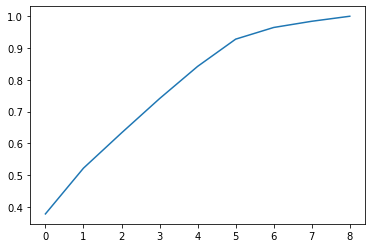

In [78]:
# model description end fit
pca = PCA()

# fiting model
pca = pca.fit(X_scaler)

# ploting cumulative sum
np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

Os autovetores indicam que 6 dimensões parecem explicar 95% de toda variabilidade das features

# 6.0 Data Preparation

### 6.1 Preprocessing

In [76]:
# backup
df_ = df.copy()

In [77]:
# backup
df = df_.copy()

# Feature Encoding
features_dum = 'Vehicle_Age'.split()
temp = pd.get_dummies(df['Vehicle_Age'], prefix='Vehicle_Age', drop_first=True)
temp.columns = ['Vehicle_Age_Menor_que_1', 'Vehicle_Age_Maior_que_2']
df = pd.concat([df, temp], axis=1)

# Removendo features que não seguirão para modelagem
features_remover = ['id', 'Gender', 'Vehicle_Age', 'Vehicle_Age_', 'Vehicle_Damage', 'Policy_Sales_Channel', 
                    'Region_Code', 'Vintage', 'Annual_Premium']
df.drop(features_remover, axis=1, inplace=True)

# Listando as colunas
target = ['Response']
cols = pd.Series(df.drop(target, axis=1).columns.to_list())

# Split X and y
train = df.loc[df['Response'].notnull()]
test = df.loc[df['Response'].isnull()]
X = train.drop(target, axis=1)
y = train[target]
y = np.array(y).reshape(1, len(y))[0]

# Standard Scaler
X_scaler = StandardScaler().fit_transform(X)

# Split train end test
X_, X_test, y_, y_test = train_test_split(X_scaler, y, test_size=0.2, random_state=101)

# Split train_ end valid
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.3, random_state=101)

# Resolvendo desbalanceamento
# Nearmiss
near = NearMiss()
X_near, y_near = near.fit_resample(X_, y_)
X_train_near, y_train_near = near.fit_resample(X_train, y_train)

# Smote
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_, y_)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

### 6.2 Feature Selection

###### 6.2.1 Principais Insights:
1. As features com maior relevância identificadas através de Exploração de Dados foram: Vehicle_Damage, Previously_Insured, Vehicle_Age, Policy_Sales_Channels_Response_Mean, Age
2. 6 Dimensões compõem 95% de toda a variabilidade das features.
3. A feature Driving_License não agrega ao modelo

###### 6.2.2 Por Correlação

In [79]:
correlations = abs(train.corr()['Response'].drop('Response', axis=0))
correlations
ranking = pd.DataFrame()
ranking['correlations'] = correlations

###### 6.2.3 RFE (Ranking por eliminação recursiva)

In [80]:
# model description
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='error')

In [81]:
# # rfe description
# rfe_model = RFE(xgb_model, 1, 1)

# # fiting model
# rfe_fit = rfe_model.fit(X_train_near, y_train_near)

# # ranking
# ranking['rfe_xgb'] = rfe_fit.ranking_
# print(rfe_fit.ranking_)
# ranking.sort_values('rfe_xgb', ascending=False).index.to_list()

###### 6.2.4 Importances

Random Forest

In [82]:
# fiting model
rf_model = RandomForestClassifier()
rf_fit = rf_model.fit(X_train_smote, y_train_smote)

# preditions
rf_predict = rf_fit.predict(X_valid)
ranking['importance_rf'] = rf_model.feature_importances_

# metrics
print(classification_report(y_valid, rf_predict))

              precision    recall  f1-score   support

         0.0       0.93      0.81      0.87     80152
         1.0       0.31      0.59      0.40     11315

    accuracy                           0.79     91467
   macro avg       0.62      0.70      0.64     91467
weighted avg       0.86      0.79      0.81     91467



Alta preferência por features numéricas, não confere com a exploração de dados, possivelmente overfitado.

XGBoost

In [83]:
# fiting model
xgb_fit = xgb_model.fit(X_train_smote, y_train_smote)

# predictions
xgb_predict = xgb_fit.predict(X_valid)
ranking['importance_xgb'] = xgb_model.feature_importances_

# metrics
print(classification_report(y_valid, xgb_predict))

              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85     80152
         1.0       0.32      0.77      0.45     11315

    accuracy                           0.77     91467
   macro avg       0.64      0.77      0.65     91467
weighted avg       0.88      0.77      0.80     91467



###### 6.2.5 Boruta

In [84]:
# # model descrition
# boruta_model = BorutaPy(xgb_model(), random_state=101)

# # fiting model
# boruta_fit = boruta_model.fit(X_train_near, y_train_near)

# # ranking features
# ranking['boruta'] = boruta_fit.ranking_
# print(boruta_fit.ranking_)
# ranking.sort_values('boruta', ascending=False).index.to_list()

In [85]:
# ranking_boruta = [1, 2, 1, 1, 1, 1, 1, 1, 1, 1]
# ranking['boruta'] = ranking_boruta

###### 6.2.6 Chosen features

<AxesSubplot:>

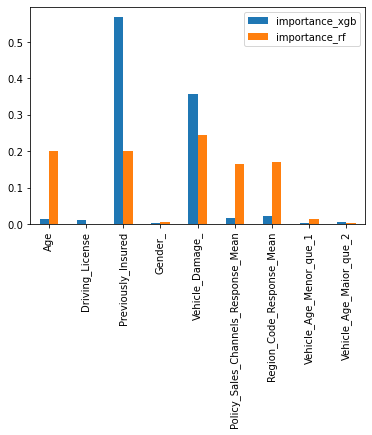

In [86]:
ranking[['importance_xgb', 'importance_rf']].plot.bar()

In [87]:
# Removendo features desinteressantes segundo a Feature Selection
remover_features_ = ['Driving_License']

X_smote = pd.DataFrame(X_smote, columns=X.columns)
X_train_smote = pd.DataFrame(X_train_smote, columns=X.columns)
X_valid = pd.DataFrame(X_valid, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

X_smote.drop(remover_features_, axis=1, inplace=True)
X_train_smote.drop(remover_features_, axis=1, inplace=True)
X_valid.drop(remover_features_, axis=1, inplace=True)
X_test.drop(remover_features_, axis=1, inplace=True)

X_smote = X_smote.to_numpy()
X_train_smote = X_train_smote.to_numpy()
X_valid = X_valid.to_numpy()
X_test = X_test.to_numpy()

# 7.0 ML Modeling

##### 7.1 Principais Insights:
1. A métrica para escolha do modelo final e predições será ROC_AUC, para responder às perguntas de negócio serão utilizadas as métricas PRECISION e RECALL do evento ocorrer, portanto as três serão abordadas
2. **Chosen model:**

###### 7.2 Log
1. Modelo XGBoostt: PRECISION de 0.33, RECALL de 0.63 e ROC_AUC 0.73
2. Modelo Random Forest: PRECISION de 0.32, RECALL de 0.41 e ROC_AUC 0.64
3. Modelo Logistic Regression: PRECISION de 0.27, RECALL de 0.93 e ROC_AUC 0.79
4. Modelo SVM: PRECISION de 0.xx, RECALL de 0.xx e ROC_AUC 0.xx
5. Modelo KNN: PRECISION de 0.29, RECALL de 0.63 e ROC_AUC 0.71

###### 7.3 XGBoost

In [88]:
# # model description
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='error')

# # fiting model
# xgb_fit = xgb_model.fit(X_smote, y_smote)
# xgb_predict = xgb_fit.predict(X_valid)

# print('Treino\n')
# print(classification_report(y_valid, xgb_predict))
# xgb_roc_auc_train = roc_auc_score(y_valid, xgb_predict)
# print(f'roc_auc_score: {round(xgb_roc_auc_train, 2)}')
# xgb_predict = xgb_fit.predict(X_test)
# print()
# print('Teste\n')
# print(classification_report(y_test, xgb_predict))
# xgb_roc_auc_test = roc_auc_score(y_test, xgb_predict)
# print(f'roc_auc_score: {round(xgb_roc_auc_test, 2)}')
# xgb_overfiting = xgb_roc_auc_train/xgb_roc_auc_test - 1
# print(f'O modelo está overfitando em {round(xgb_overfiting, 2)}%')

##### 7.4 Random Forest

In [89]:
# model definition
rf_model = RandomForestClassifier()

# fiting model
rf_fit = rf_model.fit(X_smote, y_smote)
rf_predict = rf_fit.predict(X_valid)

print('Treino\n')
print(classification_report(y_valid, rf_predict))
rf_roc_auc_train = roc_auc_score(y_valid, rf_predict)
print(f'roc_auc_score: {round(rf_roc_auc_train, 2)}')
rf_predict = rf_fit.predict(X_test)
print()
print('Teste\n')
print(classification_report(y_test, rf_predict))
rf_roc_auc_test = roc_auc_score(y_test, rf_predict)
print(f'roc_auc_score: {round(rf_roc_auc_test, 2)}')
rf_overfiting = rf_roc_auc_train/rf_roc_auc_test - 1
print(f'O modelo está overfitando em {round(rf_overfiting, 2)}%')

Treino

              precision    recall  f1-score   support

         0.0       0.97      0.83      0.89     80152
         1.0       0.40      0.82      0.54     11315

    accuracy                           0.83     91467
   macro avg       0.69      0.83      0.72     91467
weighted avg       0.90      0.83      0.85     91467

roc_auc_score: 0.83

Teste

              precision    recall  f1-score   support

         0.0       0.94      0.80      0.87     66971
         1.0       0.31      0.63      0.41      9251

    accuracy                           0.78     76222
   macro avg       0.62      0.72      0.64     76222
weighted avg       0.86      0.78      0.81     76222

roc_auc_score: 0.72
O modelo está overfitando em 0.15%


##### 7.5 Logistic Regression

In [90]:
# # model description
# lr_model = LogisticRegression()

# # fiting model
# lr_fit = lr_model.fit(X_smote, y_smote)
# lr_predict = lr_fit.predict(X_valid)

# print('Treino\n')
# print(classification_report(y_valid, lr_predict))
# lr_roc_auc_train = roc_auc_score(y_valid, lr_predict)
# print(f'roc_auc_score: {round(lr_roc_auc_train, 2)}')
# lr_predict = lr_fit.predict(X_test)
# print()
# print('Teste\n')
# print(classification_report(y_test, lr_predict))
# lr_roc_auc_test = roc_auc_score(y_test, lr_predict)
# print(f'roc_auc_score: {round(lr_roc_auc_test, 2)}')
# lr_overfiting = rf_roc_auc_train/lr_roc_auc_test - 1
# print(f'O modelo está overfitando em {round(lr_overfiting, 2)}%')

##### 7.6 Suport Vector Machine

In [91]:
# # model description
# svm_model = SVC()

# # fiting model
# svm_fit = svm_model.fit(X_smote, y_smote)
# svm_predict = svm_fit.predict(X_valid)

# print('Treino\n')
# print(classification_report(y_valid, svm_predict))
# svm_roc_auc_train = roc_auc_score(y_valid, svm_predict)
# print(f'roc_auc_score: {round(svm_roc_auc_train, 2)}')
# svm_predict = svm_fit.predict(X_test)
# print()
# print('Teste\n')
# print(classification_report(y_test, svm_predict))
# svm_roc_auc_test = roc_auc_score(y_test, svm_predict)
# print(f'roc_auc_score: {round(svm_roc_auc_test, 2)}')
# svm_overfiting = svm_roc_auc_train/svm_roc_auc_test - 1
# print(f'O modelo está overfitando em {round(svm_overfiting, 2)}%')

##### 7.7 KNN

In [92]:
# # model description
# neigh_model = KNeighborsClassifier()

# # fiting model
# neigh_fit = neigh_model.fit(X_smote, y_smote)
# neigh_predict = neigh_fit.predict(X_valid)

# print('Treino\n')
# print(classification_report(y_valid, neigh_predict))
# neigh_roc_auc_train = roc_auc_score(y_valid, neigh_predict)
# print(f'roc_auc_score: {round(neigh_roc_auc_train, 2)}')
# neigh_predict = neigh_fit.predict(X_test)
# print()
# print('Teste\n')
# print(classification_report(y_test, neigh_predict))
# neigh_roc_auc_test = roc_auc_score(y_test, neigh_predict)
# print(f'roc_auc_score: {round(neigh_roc_auc_test, 2)}')
# neigh_overfiting = neigh_roc_auc_train/neigh_roc_auc_test - 1
# print(f'O modelo está overfitando em {round(neigh_overfiting, 2)}%')

# 8.0 Predicts

# 9.0 Deploy

In [127]:
# Save trained model
pickle.dump(rf_fit, open('C:\\Users\\Notebook\\Google Drive\\Pessoal\\Projetos\\insurance_sales_predict\\deploy\\model_insurance_predict.pkl', 'wb'))

# 10.0 Results and Conclusions

# Time

In [93]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-time_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 31 minutos


# Continua...